In [ ]:
# Setup for Google Colab
!pip install transformers
!git clone https://github.com/CodyBurker/W266_Group_Project
!pip install datasets

     |████████████████████████████████| 3.8 MB 15.9 MB/s 
     |████████████████████████████████| 895 kB 90.1 MB/s 
     |████████████████████████████████| 596 kB 61.8 MB/s 
     |████████████████████████████████| 6.5 MB 95.5 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Cloning into 'W266_Group_Project'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 164 (delta 65), reused 51 (delta 8), pack-reused 0
Receiving objects: 100% (164/164), 136.69 MiB | 18.72 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Checking out files: 100% (34/34), done.
     |████████████████████████████████| 325 kB 15.9 MB/s 
     |████████████████████████████████| 1.1 MB 94.0 MB/s 
     |████████████████████████████████| 212 kB 96.0 MB/s 
   

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 27 15:05:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def read_in_data(path="W266_Group_Project/"):
    import pandas as pd
    X_train = pd.read_csv(path + "x_train_stage_1_sampled_yelp_data.csv")
    y_train = pd.read_csv(path + "y_train_stage_1_sampled_yelp_data.csv")
    X_test = pd.read_csv(path + "x_test_sampled_yelp_data_NEW.csv")
    y_test = pd.read_csv(path + "y_test_sampled_yelp_data_NEW.csv")
    X_train_stage_2 = pd.read_csv(path + "x_train_stage_2_sampled_yelp_data.csv")
    y_train_stage_2 = pd.read_csv(path + "y_train_stage_2_sampled_yelp_data.csv")
    return X_train, X_test, y_train, y_test, X_train_stage_2, y_train_stage_2
X_train, X_test, y_train, y_test, X_train_stage_2, y_train_stage_2 = read_in_data()

In [ ]:
# shifting predicted categories down by 1 to work in the sparse_cateforial_entropy loss below 

y_train['stars'] = y_train['stars'] - 1
y_test['stars'] = y_test['stars'] - 1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


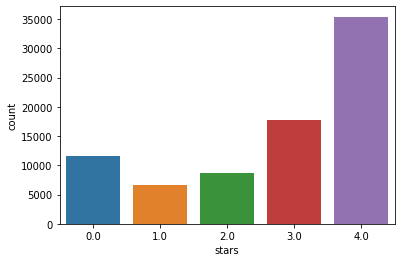

In [ ]:
sns.countplot(y_train['stars'])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
num_train_examples = 80000
num_test_examples = 20000

max_length = 512

X_train_tokenized = tokenizer([str(x.numpy())[2:] for x in tf.convert_to_tensor(X_train['text'][:num_train_examples])], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

y_train_tokenized = tf.convert_to_tensor(y_train['stars'][:num_train_examples])

x_test_tokenized = tokenizer([str(x.numpy())[2:] for x in tf.convert_to_tensor(X_test['text'][:num_test_examples])], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

y_test_tokenized = tf.convert_to_tensor(y_test['stars'][:num_test_examples])

In [ ]:
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_types_ids_layer')
attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks_layer')

In [ ]:
bert_inputs = {'input_ids': input_ids,
               'token_type_ids': token_type_ids,
               'attention_masks': attention_masks
               }

In [ ]:
bert_out = bert_model(bert_inputs)[1]

In [ ]:
hidden_out = tf.keras.layers.Dense(200, activation='relu')(bert_out)


In [ ]:
classification_out = tf.keras.layers.Dense(5, activation='sigmoid')(hidden_out)

In [ ]:
classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_masks], outputs=[classification_out])

In [ ]:
classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.00001), 
                             loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                             metrics='accuracy')

In [ ]:
classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_masks_layer (InputLa  [(None, 512)]       0           []                               
 yer)                                                                                             
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 token_types_ids_layer (InputLa  [(None, 512)]       0           []                               
 yer)                                                                                             
                                                                                              

In [ ]:
classification_model.fit([X_train_tokenized.input_ids, X_train_tokenized.token_type_ids, X_train_tokenized.attention_mask],
                         y_train_tokenized,
                         validation_data=([x_test_tokenized.input_ids, x_test_tokenized.token_type_ids, x_test_tokenized.attention_mask],
                                          y_test_tokenized),
                         epochs=3,
                         batch_size=10)

Epoch 1/3
8000/8000 [==============================] - 5998s 749ms/step - loss: 0.7501 - accuracy: 0.6829 - val_loss: 0.6542 - val_accuracy: 0.7204
Epoch 2/3
8000/8000 [==============================] - 5986s 748ms/step - loss: 0.6036 - accuracy: 0.7426 - val_loss: 0.6369 - val_accuracy: 0.7265
Epoch 3/3
8000/8000 [==============================] - 5987s 748ms/step - loss: 0.4996 - accuracy: 0.7905 - val_loss: 0.6637 - val_accuracy: 0.7285


In [ ]:
#tokenize the 80k for stage 2, then feed into preds
num_train_examples = 80000

max_length = 512

X_train_stage_2_tokenized = tokenizer([str(x.numpy())[2:] for x in tf.convert_to_tensor(X_train_stage_2['text'][:num_train_examples])], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

In [ ]:
predictions = classification_model.predict([X_train_stage_2_tokenized.input_ids, 
                                            X_train_stage_2_tokenized.token_type_ids, 
                                            X_train_stage_2_tokenized.attention_mask])

In [ ]:
predictions.shape

(80000, 5)

In [ ]:
predictions

array([[0.02485654, 0.00541492, 0.05600293, 0.7715309 , 0.9965989 ],
       [0.00448075, 0.01005913, 0.39194813, 0.94505227, 0.9398036 ],
       [0.00493906, 0.00781136, 0.32871127, 0.9510869 , 0.9584817 ],
       ...,
       [0.0096079 , 0.00909165, 0.1656906 , 0.88125306, 0.98347497],
       [0.00348651, 0.0122392 , 0.46762046, 0.95101213, 0.8846211 ],
       [0.00848686, 0.05305507, 0.70383906, 0.9188478 , 0.7348218 ]],
      dtype=float32)

In [ ]:
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv('BERT_Predictions_80k_stage_2.csv')

In [ ]:
preds = []
for pred in predictions:
  preds.append(np.argmax(pred)+1)

np.unique(preds)

predictions_df_1_to_5 = pd.DataFrame(preds)
predictions_df_1_to_5.to_csv('BERT_Predictions_80k_stage_2_1_to_5.csv')

In [ ]:
# check the accuracy of stage 2 preds
np.sum(predictions_df_1_to_5[0] == y_train_stage_2['stars'])/80000
# Based on this, the BERT model spit out accurate predictions for 72.3% of the 80k stage 2 examples

0.7231625